In [1]:
import scipy
import scipy.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import cv2
import SimpleITK as sitk
import math
from IPython.display import HTML

matplotlib.rcParams['figure.figsize'] = [12,4]

In [2]:
def k2i(kspace):
    # k-space to image space; assumes that the centre of k-space is located in the centre of the array
    return np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(kspace)))

def normxcorr(x, y, scale='unbiased'):   
    # normalized cross correlation
    x += -x.mean()
    y += -y.mean()
    
    # pad shorter array if signals are different lengths
    if x.size > y.size:
        pad_amount = x.size - y.size
        y = np.append(y, np.repeat(0, pad_amount))
    elif y.size > x.size:
        pad_amount = y.size - x.size
        x = np.append(x, np.repeat(0, pad_amount))

    corr = np.correlate(x, y, mode='full')  # scale = 'none'
    lags = np.arange(-(x.size - 1), x.size)

    if scale == 'biased':
        corr /= x.size
    elif scale == 'unbiased':
        corr /= np.maximum((x.size - abs(lags)),1.0)
        
    return corr, lags

In [3]:
# Load example dataset: 
# k-space contains the fully sampled data, At contains the sampling matrix at each heartbeat (t),
# NAV_1D, NAV_2D, NAV_3D correspond to navigators that can be used to measure respiratory motion
data_path = 'path/to/ExampleDATA1.mat'
data = scipy.io.loadmat(data_path)
At     = data['At']
kSpace = data['kSpace']

(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'))

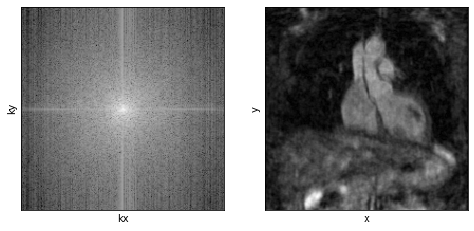

In [4]:
# Original k-space and image reconstructed without motion correction
image = k2i(kSpace)

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(kSpace[:,:,kSpace.shape[2]//2+1])),'gray')
plt.xticks([]), plt.yticks([])
plt.xlabel('kx'), plt.ylabel('ky')

plt.subplot(1,2,2)
plt.imshow(np.abs(image[:,:,image.shape[2]//2-10]),'gray',interpolation='None')
plt.xticks([]), plt.yticks([])
plt.xlabel('x'), plt.ylabel('y')

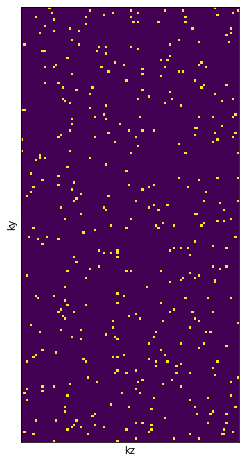

In [5]:
# Animation through At sampling matrices
fig = plt.figure( figsize=(4,8) )
a   = At[At.shape[0]//2+1,:,:,1]
im  = plt.imshow(a, interpolation='none')
plt.xticks([]), plt.yticks([])
plt.xlabel('kz'), plt.ylabel('ky')

def animate_func(i):
    im.set_array(At[At.shape[0]//2+1,:,:,i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = At.shape[3], interval = 500)
HTML(anim.to_html5_video())

(<matplotlib.image.AxesImage at 0x16a6eda60>, Text(0.5, 1.0, 'NAV 3D'))

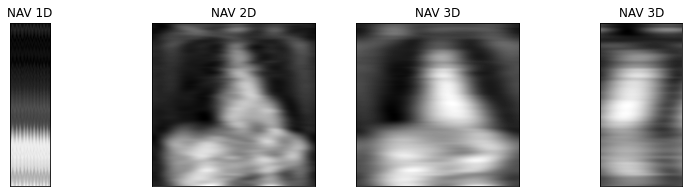

In [6]:
## Extract image navigator signal

NAV_1D = data['NAV_1D']
NAV_2D = data['NAV_2D']
NAV_3D = data['NAV_3D']

fig = plt.figure(figsize=(14,3))
plt.subplot(1,4,1), plt.xticks([]), plt.yticks([])
plt.imshow(NAV_1D,'gray',aspect='equal'), plt.title('NAV 1D')

plt.subplot(1,4,2), plt.xticks([]), plt.yticks([])
plt.imshow(NAV_2D[:,:,1],'gray',aspect='equal'), plt.title('NAV 2D')

plt.subplot(1,4,3), plt.xticks([]), plt.yticks([])
plt.imshow(NAV_3D[:,:,NAV_3D.shape[2]//2,1],'gray',aspect='equal'), plt.title('NAV 3D')
plt.subplot(1,4,4), plt.xticks([]), plt.yticks([])
plt.imshow(NAV_3D[:,NAV_3D.shape[1]//2,:,1],'gray',aspect='equal'), plt.title('NAV 3D')

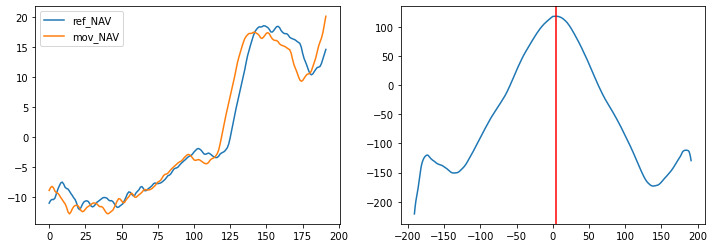

In [7]:
## Estimation & correction of respiratory motion from 1D navigators

# Example 1D navigators. Normalised cross-correlation can be used to estimate the shift between 
# two signals; t_SI can be approximated by the distance that maximizes the cross-correlation
ref_NAV = NAV_1D[:,0]
mov_NAV = NAV_1D[:,16]

c,lags = normxcorr(ref_NAV ,mov_NAV)
lag = lags[np.argmax(c)]

fig = plt.figure( figsize=(12,4) )
plt.subplot(1,2,1)
plt.plot(ref_NAV, label="ref_NAV")
plt.plot(mov_NAV, label="mov_NAV")
plt.legend(loc="upper left")
plt.subplot(1,2,2)
plt.plot(lags,c)
plt.axvline(x=lag, color='r')

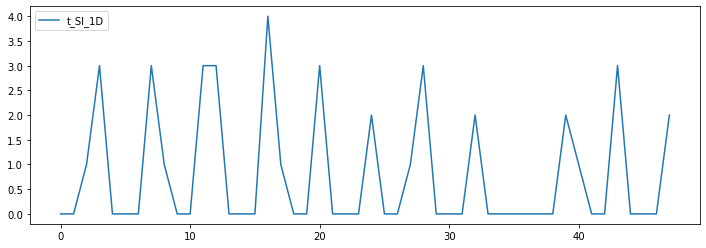

In [8]:
# Now we iterate over all the sampled navigators
translation_SI_1D = []
for ii in range(NAV_1D.shape[1]):
    c,lags = normxcorr(ref_NAV ,NAV_1D[:,ii])
    translation_SI_1D.append(lags[np.argmax(c)])

fig = plt.figure( figsize=(12,4) )
plt.plot(translation_SI_1D, label='t_SI_1D')
plt.legend(loc="upper left")

In [9]:
# Motion correction -> a translation in image space = a phase shift in k-space
x = np.arange(-kSpace.shape[0]/2,kSpace.shape[0]/2)
y = np.arange(-kSpace.shape[1]/2,kSpace.shape[1]/2)
z = np.arange(-kSpace.shape[2]/2,kSpace.shape[2]/2)

Nx,Ny,Nz = np.meshgrid(x,y,z)

kCorr_1D = []
for ii in range(NAV_1D.shape[1]):
    # A phase shift with the corresponding SI translation is applied
    kTmp = kSpace * np.exp(-(1j)*2.0*math.pi*(translation_SI_1D[ii]*Ny/kSpace.shape[1]));
    kCorr_1D.append(kTmp*At[:,:,:,ii]) 
    # only keep the data sampled at the corresponding heartbeat     

kCorr_1D  = np.stack(kCorr_1D).sum(axis=0)
imCorr_1D = k2i(kCorr_1D)

(Text(0.5, 1.0, 'Motion corrected with NAV_1D'), ([], []), ([], []))

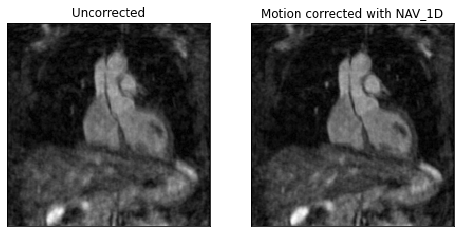

In [10]:
# Comparison between uncorrected and 1D corrected dataset
fig = plt.figure( figsize=(8,4) )
plt.subplot(1,2,1), plt.imshow(np.abs(image[:,:,image.shape[2]//2-10]),'gray',interpolation='None')
plt.title('Uncorrected'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(np.abs(imCorr_1D[:,:,image.shape[2]//2-10]),'gray',interpolation='None')
plt.title('Motion corrected with NAV_1D'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'mov_NAV'), ([], []), ([], []))

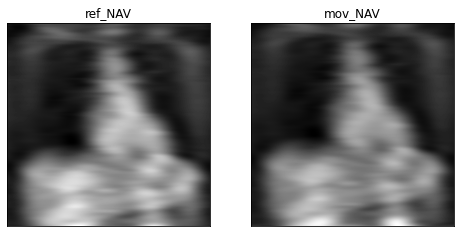

In [11]:
## Estimation & correction of respiratory motion from 2D navigators

# Example 2D navigators - low resolution images to track respiratory motion
ref_NAV = NAV_2D[:,:,0]
mov_NAV = NAV_2D[:,:,16]

fig = plt.figure( figsize=(8,4) )
plt.subplot(1,2,1)
plt.imshow(ref_NAV,'gray')
plt.title("ref_NAV"), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(mov_NAV,'gray')
plt.title("mov_NAV"), plt.xticks([]), plt.yticks([])

In [12]:
# Example 2D navigators. Normalised cross-correlation can also be used to find translation 
# between the two signals. We select a template focusing on the heart to do this.

# Coordinates of tracking template
temp_coord = [66,159,73,135]

ref_img = np.uint8(ref_NAV/NAV_2D.max()*255).copy()
mov_img = np.uint8(mov_NAV/NAV_2D.max()*255).copy()

template = np.uint8(ref_NAV[temp_coord[2]:temp_coord[3],
                            temp_coord[0]:temp_coord[1]]/NAV_2D.max()*255).copy()

# Normalised cross-correlation between the template and the moving image
res = cv2.matchTemplate(mov_img,template,cv2.TM_CCORR_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# Motion = displacement of the template compared to original position
print(f't_SI = {temp_coord[2]-max_loc[1]} \nt_RL = {temp_coord[0]-max_loc[0]}')

t_SI = 7 
t_RL = 1


(Text(0.5, 1.0, 'mov_NAV'), ([], []), ([], []))

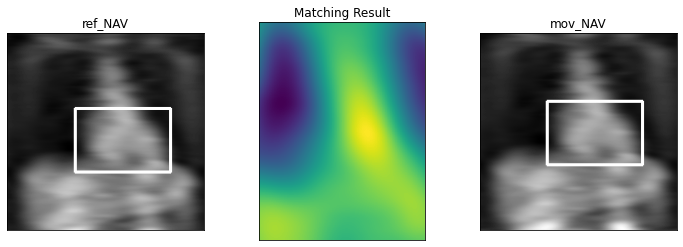

In [13]:
# Show results
fig = plt.figure( figsize=(12,4) )
plt.subplot(1,3,1), plt.title("ref_NAV"), plt.xticks([]), plt.yticks([])
cv2.rectangle(ref_img, (temp_coord[0],temp_coord[2]), (temp_coord[1],temp_coord[3]), 255, 2)
plt.imshow(ref_img,'gray')

plt.subplot(1,3,2), plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.imshow(res)

plt.subplot(1,3,3), plt.title('mov_NAV'), plt.xticks([]), plt.yticks([])
cv2.rectangle(mov_img, max_loc, (max_loc[0]+template.shape[1],max_loc[1]+template.shape[0]), 255, 2)
plt.imshow(mov_img,'gray')

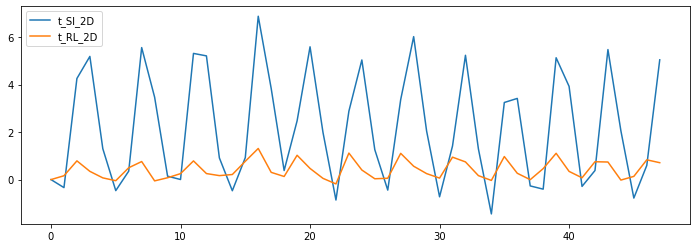

In [14]:
# An alternative way is to use image registration
ref_img = sitk.GetImageFromArray(ref_NAV)

# We can include the template for image registration as a mask
mask = np.zeros(ref_NAV.shape)
mask[temp_coord[2]:temp_coord[3],temp_coord[0]:temp_coord[1]] = 1
mask = sitk.GetImageFromArray(mask)

R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsRegularStepGradientDescent(4.0, 0.01, 200)
R.SetInitialTransform(sitk.TranslationTransform(ref_img.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)
R.SetMetricFixedMask(mask)

translation_SI_2D = []
translation_RL_2D = []
for ii in range(NAV_2D.shape[2]):
    mov_img = sitk.GetImageFromArray(NAV_2D[:,:,ii])
    outTx = R.Execute(ref_img, mov_img)
    # Important: check convention of sitk for the order of dimensions
    translation_SI_2D.append(-outTx.GetOffset()[1])
    translation_RL_2D.append(-outTx.GetOffset()[0])

fig = plt.figure( figsize=(12,4) )
plt.plot(translation_SI_2D, label='t_SI_2D')
plt.plot(translation_RL_2D, label='t_RL_2D')
plt.legend(loc="upper left")

In [15]:
# Motion correction -> a translation in image space = a phase shift in k-space
x = np.arange(-kSpace.shape[0]/2,kSpace.shape[0]/2)
y = np.arange(-kSpace.shape[1]/2,kSpace.shape[1]/2)
z = np.arange(-kSpace.shape[2]/2,kSpace.shape[2]/2)

Nx,Ny,Nz = np.meshgrid(x,y,z)

kCorr_2D = []
for ii in range(NAV_1D.shape[1]):
    # A phase shift with the corresponding SI & RL translation is applied
    kTmp = kSpace * np.exp(-(1j)*2.0*math.pi*(translation_SI_2D[ii]*Ny/kSpace.shape[1]
                                              +translation_RL_2D[ii]*Nx/kSpace.shape[0]));
    kCorr_2D.append(kTmp*At[:,:,:,ii]) 
    # only keep the data sampled at the corresponding heartbeat 
    
kCorr_2D  = np.stack(kCorr_2D).sum(axis=0)
imCorr_2D = k2i(kCorr_2D)

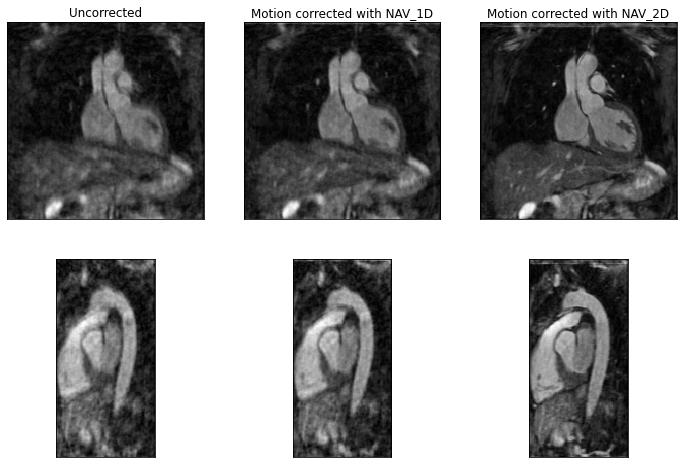

In [16]:
# Comparison between uncorrected, and corrected datasets with NAV_1D and NAV_2D
fig = plt.figure( figsize=(12,8) )
plt.subplot(2,3,1), plt.title('Uncorrected'), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(image[:,:,image.shape[2]//2-10]),'gray',interpolation='None')

plt.subplot(2,3,2), plt.title('Motion corrected with NAV_1D'), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_1D[:,:,image.shape[2]//2-10]),'gray',interpolation='None')

plt.subplot(2,3,3), plt.title('Motion corrected with NAV_2D'), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_2D[:,:,image.shape[2]//2-10]),'gray',interpolation='None')

plt.subplot(2,3,4), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(image[:,image.shape[1]//2+15,:]),'gray',interpolation='None')

plt.subplot(2,3,5), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_1D[:,image.shape[1]//2+15,:]),'gray',interpolation='None')

plt.subplot(2,3,6), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_2D[:,image.shape[1]//2+15,:]),'gray',interpolation='None')

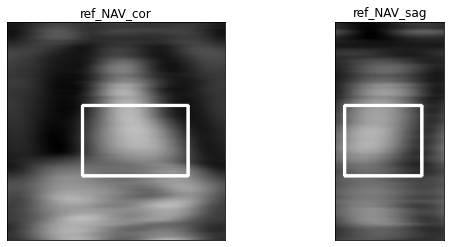

In [17]:
## Estimation & correction of respiratory motion from 3D navigators

# Example 3D navigators - low-res 3D images allows to estimate motion in the AP direction 
ref_NAV = NAV_3D[:,:,:,0]

# Coordinates of 3D tracking template
temp_coord = [66,159,73,135,8,76]

ref_cor = np.uint8(ref_NAV[:,:,ref_NAV.shape[2]//2]/NAV_3D.max()*255).copy()
ref_sag = np.uint8(ref_NAV[:,ref_NAV.shape[1]//2,:]/NAV_3D.max()*255).copy()

fig = plt.figure( figsize=(9,4) )
plt.subplot(1,2,1), plt.title("ref_NAV_cor"), plt.xticks([]), plt.yticks([])
cv2.rectangle(ref_cor,(temp_coord[0],temp_coord[2]),(temp_coord[1],temp_coord[3]),255, 2)
plt.imshow(ref_cor,'gray')

plt.subplot(1,2,2), plt.title("ref_NAV_sag"), plt.xticks([]), plt.yticks([])
cv2.rectangle(ref_sag,(temp_coord[4],temp_coord[2]),(temp_coord[5],temp_coord[3]),255, 2)
plt.imshow(ref_sag,'gray')

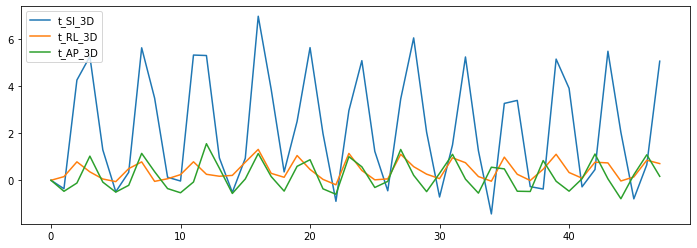

In [18]:
# Similar to the 2D case, image registration can be used to estimate SI, RL, AP motion
ref_img = sitk.GetImageFromArray(ref_NAV)
mask    = np.zeros(ref_NAV.shape)
mask[temp_coord[2]:temp_coord[3],temp_coord[0]:temp_coord[1],temp_coord[4]:temp_coord[5]] = 1
mask    = sitk.GetImageFromArray(mask)

R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsRegularStepGradientDescent(4.0, 0.01, 200)
R.SetInitialTransform(sitk.TranslationTransform(ref_img.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)
R.SetMetricFixedMask(mask)

translation_SI_3D = []
translation_RL_3D = []
translation_AP_3D = []
for ii in range(NAV_3D.shape[3]):
    mov_img = sitk.GetImageFromArray(NAV_3D[:,:,:,ii])
    outTx   = R.Execute(ref_img, mov_img)
    translation_SI_3D.append(-outTx.GetOffset()[2])
    translation_RL_3D.append(-outTx.GetOffset()[1])
    translation_AP_3D.append(-outTx.GetOffset()[0])

fig = plt.figure( figsize=(12,4) )
plt.plot(translation_SI_3D, label='t_SI_3D')
plt.plot(translation_RL_3D, label='t_RL_3D')
plt.plot(translation_AP_3D, label='t_AP_3D')
plt.legend(loc="upper left")

In [19]:
# Motion correction - a translation in image space = a phase shift in k-space
x = np.arange(-kSpace.shape[0]/2,kSpace.shape[0]/2)
y = np.arange(-kSpace.shape[1]/2,kSpace.shape[1]/2)
z = np.arange(-kSpace.shape[2]/2,kSpace.shape[2]/2)

Nx,Ny,Nz = np.meshgrid(x,y,z)

kCorr_3D = []
for ii in range(NAV_1D.shape[1]):
    # A phase shift with the corresponding SI, RL and AP translation is applied
    kTmp = kSpace * np.exp(-(1j)*2.0*math.pi*(translation_SI_3D[ii]*Ny/kSpace.shape[1]
                                              +translation_RL_3D[ii]*Nx/kSpace.shape[0]
                                              +translation_AP_3D[ii]*Nz/kSpace.shape[2]));
    kCorr_3D.append(kTmp*At[:,:,:,ii]) 
    # only keep the data sampled at the corresponding heartbeat
    
kCorr_3D  = np.stack(kCorr_3D).sum(axis=0)
imCorr_3D = k2i(kCorr_3D)

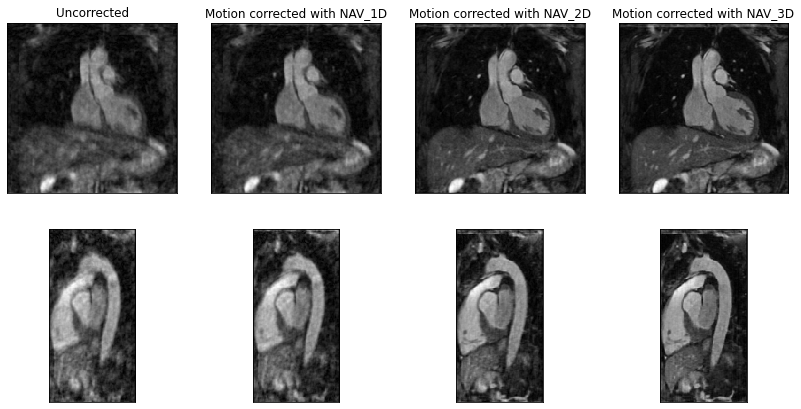

In [20]:
fig = plt.figure( figsize=(14,7) )

plt.subplot(2,4,1), plt.title('Uncorrected'), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(image[:,:,image.shape[2]//2-10]),'gray',interpolation='None')

plt.subplot(2,4,2), plt.title('Motion corrected with NAV_1D'), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_1D[:,:,image.shape[2]//2-10]),'gray',interpolation='None')

plt.subplot(2,4,3), plt.title('Motion corrected with NAV_2D'), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_2D[:,:,image.shape[2]//2-10]),'gray',interpolation='None')

plt.subplot(2,4,4), plt.title('Motion corrected with NAV_3D'), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_3D[:,:,image.shape[2]//2-10]),'gray',interpolation='None')

plt.subplot(2,4,5), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(image[:,image.shape[1]//2+15,:]),'gray',interpolation='None')

plt.subplot(2,4,6), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_1D[:,image.shape[1]//2+15,:]),'gray',interpolation='None')

plt.subplot(2,4,7), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_2D[:,image.shape[1]//2+15,:]),'gray',interpolation='None')

plt.subplot(2,4,8), plt.xticks([]), plt.yticks([])
plt.imshow(np.abs(imCorr_3D[:,image.shape[1]//2+15,:]),'gray',interpolation='None')

In [21]:
# end of script